# Configuration (by bombedhair)
## 아래 셀에 마우스를 대고 Ctrl + Enter를 눌러주세요

In [1]:
import requests
import json

URL_SEASONS = "https://api.battle.pokemon-home.com/cbd/competition/rankmatch/list"
URL_TRAINER = "https://resource.pokemon-home.com/battledata/ranking/{mid}/{rst}/{ts}/traner-{idx}"
URL_POKEMON = "https://resource.pokemon-home.com/battledata/ranking/{mid}/{rst}/{ts}/pokemon"
URL_PDETAIL = "https://resource.pokemon-home.com/battledata/ranking/{mid}/{rst}/{ts}/pdetail-{idx}"

headers = {
    "Host": "resource.pokemon-home.com",
    "Connection": "close",
    "Accept": "application/json, text/javascript, */*; q=0.01",
    "User-Agent": "Mozilla/5.0 (Android 10; Mobile; rv:78.0) AppleWebKit/537.36 (KHTML, like Gecko)",
    "X-Requested-With": "XMLHttpRequest",
    "Sec-Fetch-Site": "same-origin",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Dest": "empty",
    "Referer": "https://resource.pokemon-home.com/battledata/rankmatch_detail.html",
    "Accept-Encoding": "gzip, deflate",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7"
}

def get_seasons():
    extra_headers = {
        "Host": "api.battle.pokemon-home.com",
        "countrycode": "305", #Korea
        "langcode": "8", #KOR
        "Authorization": "Bearer",
        "X-Requested-With": "jp.pokemon.pokemonhome",
        "Sec-Fetch-Site": "same-site"
    }
    
    data = {
        "soft": "Sw" #Sword
    }
    response = requests.post(URL_SEASONS, headers={**headers, **extra_headers}, json=data)
    if response.status_code != 200:
        raise Exception("서버로부터 정상적인 응답을 받지 못했습니다. HTTP 응답 코드 {}".format(response.status_code))
    
    try:
        response = json.loads(response.text)
    except:
        raise Exception("서버로부터 받은 응답을 읽어들이지 못했습니다.\n{}".format(response.text))
    
    if response["code"] != 200:
        raise Exception("서버로부터 정상적인 응답을 받지 못했습니다. 내부 응답 코드 {}".format(response["code"]))
    
    return response["list"]

def get_trainer_rank(match, index):
    _URL = URL_TRAINER.format(
        mid = "100{}{}".format(match['season'], match['rule'] + 1),
        rst = match['rst'],
        ts = match['ts1'],
        idx = index # (순위 // 1000) + 1
    )

    response = requests.get(_URL, headers=headers)
    if response.status_code != 200:
        print(response.text)
        raise Exception("서버로부터 정상적인 응답을 받지 못했습니다. HTTP 응답 코드 {}".format(response.status_code))
    
    try:
        response = json.loads(response.text)
    except:
        raise Exception("서버로부터 받은 응답을 읽어들이지 못했습니다.\n{}".format(response.text))
    
    return response

def get_pokemon_rank(match):
    _URL = URL_POKEMON.format(
        mid = "100{}{}".format(match['season'], match['rule'] + 1),
        rst = match['rst'],
        ts = match['ts2'],
    )
    
    response = requests.get(_URL, headers=headers)
    if response.status_code != 200:
        raise Exception("서버로부터 정상적인 응답을 받지 못했습니다. HTTP 응답 코드 {}".format(response.status_code))
    
    try:
        response = json.loads(response.text)
    except:
        raise Exception("서버로부터 받은 응답을 읽어들이지 못했습니다.\n{}".format(response.text))
    
    return response

def get_pokemon_details(match):
    details = {}
    for i in range(0, 5):
        _URL = URL_PDETAIL.format(
            mid = "100{}{}".format(match['season'], match['rule'] + 1),
            rst = match['rst'],
            ts = match['ts2'],
            idx = i + 1
        )
        
        response = requests.get(_URL, headers=headers)
        if response.status_code != 200:
            raise Exception("서버로부터 정상적인 응답을 받지 못했습니다. HTTP 응답 코드 {}".format(response.status_code))
        
        try:
            response = json.loads(response.text)
            details.update(response)
        except:
            raise Exception("서버로부터 받은 응답을 읽어들이지 못했습니다.\n{}".format(response.text))

    return details

# Data Analysis 관련 Configuration
## 윈도우 사용자분들은 'AppleGothic' 대신 'NanumGothic'을 입력해주세요
## 아래 셀에 마우스를 대고 Ctrl + Enter를 눌러주세요

In [2]:
from constants import *
from datetime import datetime

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats

%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='AppleGothic')

from IPython.core.display import HTML
from functools import reduce

# Data Analysis 관련 함수

In [3]:
# 해당 시즌의 기본 정보를 보여주는 함수입니다.
def display_season_data(num):
    season = get_seasons()[str(num)]
    for match_id in sorted(season.keys()):
        match = season[match_id]
        battle_prefix = '싱글' if match['rule'] == 0 else '더블' # 0 -> 싱글, 1 -> 더블
        display(HTML(f"<h3>시즌 {num} {battle_prefix} 배틀 정보</h3>"))
        print("시즌 이름:", match['name'])
        print("시즌 시작:", match['start'])
        print("시즌 종료:", match['end'])
        print("참여자 수:", match['cnt'])
        print("플레이어 순위 집계 기준:", datetime.fromtimestamp(match['ts1']).strftime("%Y년 %m월 %d일 %H시 %M분 %S초"))
        print("포켓몬 순위 집계 기준:", datetime.fromtimestamp(match['ts2']).strftime("%Y년 %m월 %d일 %H시 %M분 %S초"))

# 원하는 시즌의 싱글 또는 더블배틀 트레이너 순위를 원하는 만큼 보여주는 함수입니다.
def display_trainer_data(season, single, start, end):
    the_season = get_seasons()[str(season)]
    
    battle_prefix = '싱글' if single else '더블'
    for rule_id in sorted(the_season.keys()):
        rule = '싱글' if rule_id.endswith('1') else '더블'
        if battle_prefix is rule:
            
            display(HTML(f"<h3>시즌 {season} {rule} 배틀 {start}위 ~ {end}위 플레이어</h3>"))
            trainers = get_trainer_rank(the_season[rule_id], 1)
            
            dataframe = (pd.DataFrame(trainers[start-1:end])
                           .drop(columns=['icon', 'lng'])
                           .rename(columns={'name': '트레이너', 'rank': '순위', 'rating_value': '레이팅'})
                           .set_index('순위'))
            display(dataframe)
            
# 원하는 시즌의 싱글 또는 더블배틀 포켓몬 빈도 순위를 원하는 만큼 보여주는 함수입니다.
def display_pokemon_usage(season, single, start, end):
    the_season = get_seasons()[str(season)]
    
    battle_prefix = '싱글' if single else '더블'
    for rule_id in sorted(the_season.keys()):
        rule = '싱글' if rule_id.endswith('1') else '더블'
        if battle_prefix is rule:
            
            display(HTML(f"<h3>시즌 {season} {rule} 배틀 빈도 {start}위 ~ {end}위 포켓몬</h3>"))
            pokemons = get_pokemon_rank(the_season[rule_id])
            for i in range(start - 1, end):
                pokemons[i]['name'] = POKEMON_NAME[pokemons[i]['id']]
                pokemons[i]['type'] = POKEMON_TYPE[pokemons[i]['id']][pokemons[i]['form']]
                pokemons[i]['type_kor'] = ', '.join([TYPE_NAME[x] for x in pokemons[i]['type']])
                pokemons[i]['ranking'] = i + 1
                
            dataframe = (pd.DataFrame(pokemons[start-1:end])
                           .drop(columns=['form', 'id', 'type'])
                           .rename(columns={'ranking': '순위', 'name': '이름', 'type_kor': '타입'})
                           .set_index('순위'))
            display(dataframe)
            
# 원하는 포켓몬의 상세 정보를 보여주는 함수입니다.
def display_pokemon_data(season, single, ranking, components):
    the_season = get_seasons()[str(season)]
    
    battle_prefix = '싱글' if single else '더블'
    for rule_id in sorted(the_season.keys()):
        rule = '싱글' if rule_id.endswith('1') else '더블'
        if battle_prefix is rule:
            
            display(HTML(f"<h3>시즌 {season} {rule} 배틀 빈도 {ranking}위 포켓몬 상세 정보</h3>"))
            pokemon = get_pokemon_rank(the_season[rule_id])[ranking - 1]
            print("이름:", POKEMON_NAME[pokemon['id']])
            print("타입:", ', '.join([TYPE_NAME[x] for x in POKEMON_TYPE[pokemon['id']][pokemon['form']]]))
            
            details = get_pokemon_details(the_season[rule_id])[str(pokemon['id'])][str(pokemon['form'])]
            
            if '기술' in components:
                moves = details['temoti']['waza']
                display(HTML('<h4>기술</h4>'))
                for i in range(0, len(moves)):
                    moves[i]['name'] = SKILL_NAME[int(moves[i]['id'])]
                    moves[i]['ranking'] = i + 1
                moves_df = (pd.DataFrame(moves)
                              .drop(columns=['id'])
                              .rename(columns={'name': '이름', 'ranking': '순위', 'val': '빈도'})
                              .set_index('순위'))
                display(moves_df)
            
            if '특성' in components:
                abilities = details['temoti']['tokusei']
                display(HTML('<h4>특성</h4>'))
                for i in range(0, len(abilities)):
                    abilities[i]['name'] = ABILITY_NAME[int(abilities[i]['id'])]
                    abilities[i]['ranking'] = i + 1
                abilities_df = (pd.DataFrame(abilities)
                              .drop(columns=['id'])
                              .rename(columns={'name': '이름', 'ranking': '순위', 'val': '빈도'})
                              .set_index('순위'))
                display(abilities_df)
            
            if '도구' in components:
                items = details['temoti']['motimono']
                display(HTML('<h4>도구</h4>'))
                for i in range(0, len(items)):
                    items[i]['name'] = ITEM_NAME[int(items[i]['id'])]
                    items[i]['ranking'] = i + 1
                items_df = (pd.DataFrame(items)
                              .drop(columns=['id'])
                              .rename(columns={'name': '이름', 'ranking': '순위', 'val': '빈도'})
                              .set_index('순위'))
                display(items_df)

            if '배틀팀' in components:
                parties = details['temoti']['pokemon']
                display(HTML('<h4>함께 배틀팀에 포함된 포켓몬 TOP 10</h4>'))
                for i in range(0, len(parties)):
                    parties[i]['name'] = POKEMON_NAME[parties[i]['id']]
                    parties[i]['type'] = POKEMON_TYPE[parties[i]['id']][parties[i]['form']]
                    parties[i]['type_kor'] = ', '.join([TYPE_NAME[x] for x in parties[i]['type']])
                    parties[i]['ranking'] = i + 1
                parties_df = (pd.DataFrame(parties)
                               .drop(columns=['form', 'id', 'type'])
                               .rename(columns={'ranking': '순위', 'name': '이름', 'type_kor': '타입'})
                               .set_index('순위'))
                display(parties_df)

            if '이긴 포켓몬' in components:
                win_pokemons = details['win']['pokemon']
                display(HTML('<h4>이 포켓몬이 쓰러뜨린 포켓몬 TOP 10</h4>'))
                for i in range(0, len(win_pokemons)):
                    win_pokemons[i]['name'] = POKEMON_NAME[win_pokemons[i]['id']]
                    win_pokemons[i]['type'] = POKEMON_TYPE[win_pokemons[i]['id']][win_pokemons[i]['form']]
                    win_pokemons[i]['type_kor'] = ', '.join([TYPE_NAME[x] for x in win_pokemons[i]['type']])
                    win_pokemons[i]['ranking'] = i + 1
                win_pokemons_df = (pd.DataFrame(win_pokemons)
                               .drop(columns=['form', 'id', 'type'])
                               .rename(columns={'ranking': '순위', 'name': '이름', 'type_kor': '타입'})
                               .set_index('순위'))
                display(win_pokemons_df)

            if '이긴 기술' in components:
                win_moves = details['win']['waza']
                display(HTML('<h4>이 포켓몬이 상대를 쓰러뜨릴 때 사용한 기술 TOP 10</h4>'))
                for i in range(0, len(win_moves)):
                    win_moves[i]['name'] = SKILL_NAME[int(win_moves[i]['id'])]
                    win_moves[i]['ranking'] = i + 1
                win_moves_df = (pd.DataFrame(win_moves)
                              .drop(columns=['id'])
                              .rename(columns={'name': '이름', 'ranking': '순위', 'val': '빈도'})
                              .set_index('순위'))
                display(win_moves_df)

            if '진 포켓몬' in components:
                lose_pokemons = details['lose']['pokemon']
                display(HTML('<h4>이 포켓몬을 쓰러뜨린 포켓몬 TOP 10</h4>'))
                for i in range(0, len(lose_pokemons)):
                    lose_pokemons[i]['name'] = POKEMON_NAME[lose_pokemons[i]['id']]
                    lose_pokemons[i]['type'] = POKEMON_TYPE[lose_pokemons[i]['id']][lose_pokemons[i]['form']]
                    lose_pokemons[i]['type_kor'] = ', '.join([TYPE_NAME[x] for x in lose_pokemons[i]['type']])
                    lose_pokemons[i]['ranking'] = i + 1
                lose_pokemons_df = (pd.DataFrame(lose_pokemons)
                               .drop(columns=['form', 'id', 'type'])
                               .rename(columns={'ranking': '순위', 'name': '이름', 'type_kor': '타입'})
                               .set_index('순위'))
                display(lose_pokemons_df)

            if '진 기술' in components:
                lose_moves = details['lose']['waza']
                display(HTML('<h4>이 포켓몬을 쓰러뜨린 기술 TOP 10</h4>'))
                for i in range(0, len(lose_moves)):
                    lose_moves[i]['name'] = SKILL_NAME[int(lose_moves[i]['id'])]
                    lose_moves[i]['ranking'] = i + 1
                lose_moves_df = (pd.DataFrame(lose_moves)
                              .drop(columns=['id'])
                              .rename(columns={'name': '이름', 'ranking': '순위', 'val': '빈도'})
                              .set_index('순위'))
                display(lose_moves_df)
                
def track_pokemon_data(pokemon, form, single, seasons, top_N, components, graphics):
    for pokemon_id, name in POKEMON_NAME.items():
        if pokemon == name:
            dex_no = pokemon_id
    
    battle_prefix = '싱글' if single else '더블'
    display(HTML(f"<h3>시즌별 {battle_prefix} 배틀 {pokemon} 상세 정보</h3>"))
    print("타입:", ', '.join([TYPE_NAME[x] for x in POKEMON_TYPE[dex_no][form]]))
    
    moves_df = {}
    abilities_df = {}
    items_df = {}
    win_moves_df = {}
    lose_moves_df = {}
    
    the_seasons = get_seasons()
    for season in seasons:
        
        for rule_id in sorted(the_seasons[str(season)].keys()):
            rule = '싱글' if rule_id.endswith('1') else '더블'
            if battle_prefix is rule:

                details = get_pokemon_details(the_seasons[str(season)][rule_id])[str(dex_no)][str(form)]

                if '기술' in components:
                    moves = details['temoti']['waza']
                    for i in range(0, len(moves)):
                        moves[i]['name'] = SKILL_NAME[int(moves[i]['id'])]
                        moves[i]['ranking'] = i + 1
                    moves_df[season] = (pd.DataFrame(moves)
                                  .drop(columns=['id'])
                                  .rename(columns={'name': '이름', 'ranking': '순위', 'val': f'시즌{season}'})
                                  .set_index('순위')
                                  .astype({f'시즌{season}': 'float64'}))
                
                if '특성' in components:
                    abilities = details['temoti']['tokusei']
                    for i in range(0, len(abilities)):
                        abilities[i]['name'] = ABILITY_NAME[int(abilities[i]['id'])]
                        abilities[i]['ranking'] = i + 1
                    abilities_df[season] = (pd.DataFrame(abilities)
                                  .drop(columns=['id'])
                                  .rename(columns={'name': '이름', 'ranking': '순위', 'val': f'시즌{season}'})
                                  .set_index('순위')
                                  .astype({f'시즌{season}': 'float64'}))

                if '도구' in components:
                    items = details['temoti']['motimono']
                    for i in range(0, len(items)):
                        items[i]['name'] = ITEM_NAME[int(items[i]['id'])]
                        items[i]['ranking'] = i + 1
                    items_df[season] = (pd.DataFrame(items)
                                  .drop(columns=['id'])
                                  .rename(columns={'name': '이름', 'ranking': '순위', 'val': f'시즌{season}'})
                                  .set_index('순위')
                                  .astype({f'시즌{season}': 'float64'}))
    
    if '기술' in components:
        display(HTML('<h4>기술</h4>'))
        moves_df_merged = (reduce(lambda left, right: pd.merge(left, right, on='이름', how='outer'),
                                 moves_df.values())
                           .sort_values(by=f'시즌{max(seasons)}', ascending=False).reset_index(drop=True)[:top_N])
        if '표' in graphics:
            moves_df_merged.index += 1
            display(moves_df_merged)
        if '그래프' in graphics:
            moves_df_merged = moves_df_merged.set_index('이름').T
            plt.figure(figsize=[15, 7])
            sns.lineplot(data=moves_df_merged, marker="o", dashes=False, sort=False)
            plt.ylabel('빈도(%)')
            plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5), loc='center left')
            plt.show()
    
    if '특성' in components:
        display(HTML('<h4>특성</h4>'))
        abilities_df_merged = (reduce(lambda left, right: pd.merge(left, right, on='이름', how='outer'),
                                 abilities_df.values())
                               .sort_values(by=f'시즌{max(seasons)}', ascending=False).reset_index(drop=True))
        if '표' in graphics:
            abilities_df_merged.index += 1
            display(abilities_df_merged)
        if '그래프' in graphics:
            abilities_df_merged = abilities_df_merged.set_index('이름').T
            plt.figure(figsize=[15, 7])
            sns.lineplot(data=abilities_df_merged, marker="o", dashes=False, sort=False)
            plt.ylabel('빈도(%)')
            plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5), loc='center left')
            plt.show()
    
    if '도구' in components:
        display(HTML('<h4>도구</h4>'))
        items_df_merged = (reduce(lambda left, right: pd.merge(left, right, on='이름', how='outer'),
                                 items_df.values())
                           .sort_values(by=f'시즌{max(seasons)}', ascending=False).reset_index(drop=True)[:top_N])
        if '표' in graphics:
            items_df_merged.index += 1
            display(items_df_merged)
        if '그래프' in graphics:
            items_df_merged = items_df_merged.set_index('이름').T
            plt.figure(figsize=[15, 7])
            sns.lineplot(data=items_df_merged, marker="o", dashes=False, sort=False)
            plt.ylabel('빈도(%)')
            plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5), loc='center left')
            plt.show()

# 이제 마음껏 원하는 데이터를 열람하세요!

## 아래에 있는 셀들을 클릭해 입맛대로 변수를 수정하시고, Ctrl + Enter를 누르시면 바로 실행됩니다.

In [4]:
# 간단히 시즌 번호를 입력해 호출하면 정보를 보여줍니다.
display_season_data(9)

시즌 이름: 시즌 9
시즌 시작: 2020. 08. 01. 13:00
시즌 종료: 2020. 09. 01. 08:59
참여자 수: 139341
플레이어 순위 집계 기준: 2020년 08월 03일 14시 19분 27초
포켓몬 순위 집계 기준: 2020년 08월 03일 14시 19분 39초


시즌 이름: 시즌 9
시즌 시작: 2020. 08. 01. 13:00
시즌 종료: 2020. 09. 01. 08:59
참여자 수: 139339
플레이어 순위 집계 기준: 2020년 08월 03일 14시 19분 27초
포켓몬 순위 집계 기준: 2020년 08월 03일 14시 19분 39초


In [5]:
# 원하는 시즌의 포켓몬 트레이너 순위를 보여줍니다.
# season은 시즌 번호, start는 시작 순위, end는 끝 순위입니다.
# single에 True를 입력하면 싱글배틀 순위를, False를 입력하면 더블배틀 순위를 보여줍니다.
display_trainer_data(season=8, single=True, start=298, end=308)

,트레이너,레이팅
순위,,
298,あさ,2013975
299,ハビル,2013920
300,하라다 가자,2013900
301,おんそに,2013891
302,okj,2013830
303,あきくけこ,2013454
304,Shield,2013353
305,ゼレット,2013347
306,ユメノ,2013161


In [6]:
# 원하는 시즌의 포켓몬 빈도 순위를 보여줍니다.
# season은 시즌 번호, start는 시작 순위, end는 끝 순위입니다.
# single에 True를 입력하면 싱글배틀 순위를, False를 입력하면 더블배틀 순위를 보여줍니다.
display_pokemon_usage(season=9, single=True, start=1, end=10)

,이름,타입
순위,,
1,에이스번,불꽃
2,토게키스,"페어리, 비행"
3,고릴타,풀
4,폴리곤2,노말
5,드래펄트,"드래곤, 고스트"
6,따라큐,"고스트, 페어리"
7,하마돈,땅
8,우라오스,"격투, 물"
9,갸라도스,"물, 비행"


In [7]:
# # 원하는 시즌, 원하는 순위의 포켓몬의 상세정보를 보여줍니다.
# season은 시즌 번호, ranking은 순위입니다.
# single에 True를 입력하면 싱글배틀 순위를, False를 입력하면 더블배틀 순위를 보여줍니다.
# components는 옵션으로, '기술', '특성', '도구', '배틀팀', '이긴 포켓몬', '이긴 기술', '진 포켓몬', '진 기술' 이 있습니다.
# 옵션을 원하는 대로 조정하여 보실 수 있습니다.
display_pokemon_data(season=9, single=False, ranking=11,
                     components=['기술', '특성', '도구'])

이름: 엘풍
타입: 풀, 페어리


,이름,빈도
순위,,
1,순풍,99.6
2,문포스,68.5
3,도발,43.5
4,도우미,31.3
5,방어,27.7
6,매지컬샤인,25.8
7,거짓울음,20.2
8,바꿔치기,15.4
9,집단구타,11.7


,이름,빈도
순위,,
1,짓궂은마음,100.0


,이름,빈도
순위,,
1,기합의띠,57.8
2,탈출버튼,18.7
3,바코열매,6.5
4,멘탈허브,5.4
5,정령플레이트,3.0
6,바리비열매,2.1
7,랑사열매,1.9
8,느림보꼬리,1.2
9,먹다남은음식,0.8


타입: 드래곤, 고스트


,이름,시즌1,시즌2,시즌3,시즌4,시즌5,시즌6,시즌7,시즌8,시즌9
1,기합의띠,16.9,10.2,10.5,12.5,9.5,8.6,18.6,17.2,18.8
2,생명의구슬,10.9,9.5,10.6,14.9,15.8,17.9,13.2,14.6,18.3
3,먹다남은음식,3.1,3.3,4.0,7.4,8.3,8.1,13.4,15.7,14.2
4,약점보험,13.7,19.5,20.4,16.2,12.4,13.9,11.4,12.3,9.5
5,구애안경,10.8,10.2,9.2,10.4,22.2,18.8,14.8,11.3,9.0
6,빛의점토,6.5,6.6,10.9,6.6,4.5,4.3,4.6,7.9,7.8
7,리샘열매,NaN,NaN,1.6,4.4,3.4,4.5,5.9,4.0,5.5
8,구애머리띠,5.6,5.1,4.9,4.7,4.4,5.6,4.1,4.1,5.2
9,구애스카프,18.9,23.3,18.4,15.1,13.0,11.7,7.1,4.6,4.2
10,달인의띠,4.4,3.5,3.1,2.4,2.0,1.9,1.9,1.8,2.1


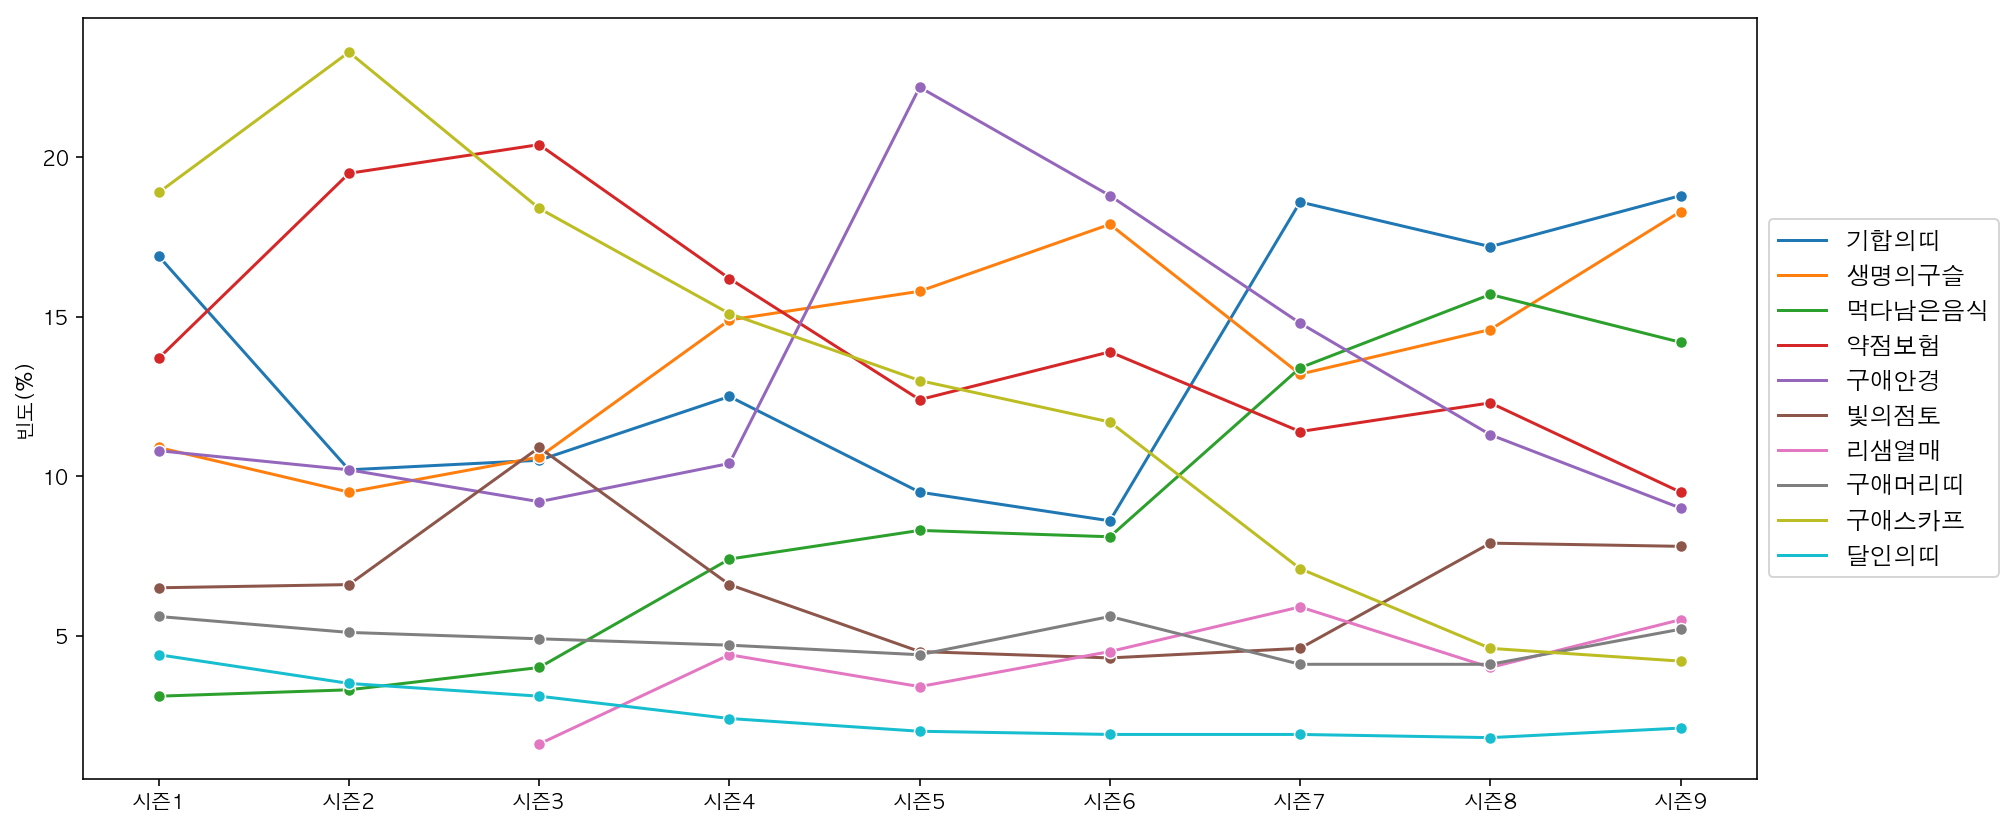

In [8]:
# # 원하는 포켓몬의 시즌별 상세정보를 표나 그래프를 통해 보여줍니다.
# pokemon은 포켓몬 이름(한칭), form은 폼체인지가 없는 경우 0을 입력하고, 폼체인지의 경우 폼체인지 번호를 입력합니다.
# 로토무의 경우, 0=기본, 1=히트, 2=워시, 3=프로스트, 4=스핀, 5=커트입니다.
# single에 True를 입력하면 싱글배틀 순위를, False를 입력하면 더블배틀 순위를 보여줍니다.
# seasons는 보기를 원하는 시즌의 리스트입니다. 입력한 순서에 따라 표와 그래프가 그려지니 주의해 주세요.
# top_N은 가장 최근 시즌을 기준으로 상위 N개의 기술/도구만 볼 수 있게 하는 기능입니다.
# components는 옵션으로, '기술', '특성', '도구'가 있습니다.
# graphics는 그래픽 선택으로, '표', '그래프'가 있습니다.
# 자세한 옵션을 주어 그래프를 그리고 싶으시다면 graph_pokemon_data 함수를 이용해 주세요.
# 옵션과 그래픽을 원하는 대로 조정하여 보실 수 있습니다.
track_pokemon_data(pokemon='드래펄트', form=0, single=True,
                   seasons=[1, 2, 3, 4, 5, 6, 7, 8, 9], top_N=10,
                   components=['도구'],
                   graphics=['표', '그래프'])